<a href="https://colab.research.google.com/github/HoangLong1907/DeepLearning-CS431/blob/main/Baitap/Phanloaicamxuc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tạo máy ảo bằng Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Kill kernel cũ đi đồng thời tạo kết nối mới

## Cài đặt các thư viện cần thiết và chứng thực

# Phân tích cảm xúc với LSTMs

Trong assignment này, chúng ta sẽ dùng mạng LSTM để giải quyết bài toán phân tích cảm xúc (Sentiment Analysis) trên tập dữ liệu văn bản. Nếu nhìn theo kiểu black box, đầu vào của bài toán là một câu hoặc đoạn văn bản và đầu ra là trạng thái tích cực, tiêu cực hay trung hoà (positive - negative - neutral). Trong phạm vi của assignment này, chúng ta chỉ quan tâm đến hai trạng thái cảm xúc là positive và negative.

![caption](Images/input_output.png)

# Góc nhìn Word Vectors

Nếu như chúng ta giữ nguyên định dạng đầu vào là chuỗi ký tự thì rất khó để thực hiện các thao tác biến đổi như tích vô hướng (dot product) hoặc các thuật toán trên mạng neural network như backpropagation. Thay vì dữ liệu đầu vào là một chuỗi, chúng ta cần chuyển đổi các từ trong tập từ điển sang dạng vector số học trong đó có thể thực hiện được các phép toán nêu trên.

![caption](Images/word2vec.png)

Trong hình minh hoạ ở trên, ta có thể hình dung dữ liệu đầu vào của thuật toán phân tích cảm xúc là một ma trận 16 x D chiều. Trong đó 16 là số lượng từ trong câu và D là số chiều của không gian vector để biểu diễn từ. Để ánh xạ từ một từ sang một vector, chúng ta sử dụng ma trận word embedding như đã thực hiện trong bài Lab 2.

## Tập dữ liệu

Trong assignment này, chúng tôi sử dụng tập dữ liệu review trên trang Foody với khoảng 30,000 mẫu được gán nhãn. Trong đó có 15,000 mẫu positive và 15,000 mẫu negative. Nguồn: https://streetcodevn.com/blog/dataset. Tập dữ liệu này đã được đính kèm trong thư mục của assignment 3.

## Các bước để huấn luyện trên mạng RNN

Có 5 bước chính để giải quyết bài toán phân tích cảm xúc trong văn bản:

    1) Huấn luyện một mô hình phát sinh ra vector từ (như mô hình Word2Vec) hoặc tải lên các vector từ tiền huấn luyện.
    2) Tạo ma trận ID cho tập dữ liệu huấn luyện
    3) Tạo mô hình RNN với các đơn vị LSTM, sử dụng tensorflow
    4) Huấn luyện mô hình RNN với dữ liệu ma trận đã tạo ở bước 2
    5) Đánh giá mô hình đã huấn luyện với tập test

# 1. Load tập từ vựng và ma trận word embedding

Đầu tiên, để có thể biến đổi một từ thành một vector, chúng ta sử dụng mô hình đã được huấn luyện trước đó (pretrained model). Mô hình đã train trước đó cho tiếng Việt được lấy ở đây: https://s3-us-west-1.amazonaws.com/fasttext-vectors/word-vectors-v2/cc.vi.300.vec.gz

Tuy nhiên, số lượng từ vựng tiếng Việt được huấn luyện rất lớn, khoảng 2M từ. Mỗi từ được biểu diễn dưới dạng một vector 300 chiều. Với kích thước gốc của ma trận word embedding như vậy sẽ gây khó khăn cho việc load dữ liệu cũng như đưa vào thư viện tensorflow để huấn luyện nên chúng tôi đã tối giản lại với số lượng từ tối thiểu để có thể chạy được trên tập dữ liệu review về đồ ăn của Foody.


In [ ]:
import numpy as np
import os
# LƯU Ý: CẦN PHẢI CHỈNH LẠI ĐƯỜNG DẪN NÀY THÀNH THƯ MỤC CHỨA CÁC FILE ASSIGNMENT3
# CHỮ 'drive' có nghĩa là thư mục mặc định của Google drive
currentDir = '/content/drive/MyDrive/DeepLearning/Foody/'

wordsList = np.load(os.path.join(currentDir, 'wordsList.npy'))
print('Simplified vocabulary loaded!')
wordsList = wordsList.tolist()
#wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load(os.path.join(currentDir, 'wordVectors.npy'))
wordVectors = np.float32(wordVectors)
print ('Word embedding matrix loaded!')

Simplified vocabulary loaded!
Word embedding matrix loaded!


Để chắc chắn mọi dữ liệu được load lên một cách chính xác, chúng ta cần kiểm tra xem số lượng từ trong từ điển rút gọn và số chiều của ma trận word embedding có khớp với nhau hay không? Trong trường hợp này số từ mà chúng tôi giữ lại là 19,899 và số chiều trong không gian biểu diễn là 300 chiều.

In [ ]:
print('Size of the vocabulary: ', len(wordsList))
print('Size of the word embedding matrix: ', wordVectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


## Word2Vec trên một từ đơn

Để có thể xác định được vector biểu diễn của một từ tiếng Việt. Đầu tiên chúng ta sẽ xác định xem vị trí của từ đó trong wordsList. Sau đó lấy vector ở dòng tương ứng trên trên ma trận wordVectors. 

In [ ]:
ngon_idx = wordsList.index('ngon')
print('Index of `ngon` in wordsList: ', ngon_idx)
ngon_vec = wordVectors[ngon_idx]
print('Vector representation of `ngon` is: ', ngon_vec)

Index of `ngon` in wordsList:  14598
Vector representation of `ngon` is:  [-2.040e-02 -9.800e-03  2.290e-01 -3.770e-02  5.430e-02 -2.680e-02
  2.190e-02 -6.290e-02 -2.200e-02 -1.010e-02  8.300e-03 -8.810e-02
 -3.630e-02  7.820e-02 -7.780e-02 -4.930e-02 -6.600e-03 -1.026e-01
 -1.040e-02  5.380e-02  4.100e-02  6.530e-02 -2.770e-02 -6.340e-02
  2.270e-02  4.420e-02  3.340e-02 -4.960e-02  8.290e-02 -3.990e-02
  3.750e-02  1.800e-02 -1.115e-01 -7.200e-02 -5.060e-02 -1.051e-01
 -4.560e-02 -1.765e-01 -3.300e-02 -6.800e-03  5.580e-02 -4.180e-02
  4.380e-02  4.940e-02  7.400e-03  4.020e-02 -8.850e-02 -9.840e-02
 -5.210e-02 -5.500e-03  3.730e-02 -8.460e-02 -6.910e-02 -4.980e-02
 -3.910e-02 -4.980e-02 -8.690e-02  6.100e-03 -5.360e-02 -3.800e-03
  1.162e-01 -4.160e-02  5.000e-03 -7.240e-02 -3.320e-02  1.800e-02
  1.200e-02 -4.420e-02  1.350e-01  6.580e-02 -1.110e-02  1.960e-02
  1.750e-02  2.010e-02  2.200e-03  1.810e-01 -6.610e-02 -6.860e-02
 -4.690e-02  7.890e-02  6.880e-02 -5.320e-02  2.770e-02

### ToDo 3.1: Word2Vec để biểu diễn một đoạn văn bản

Nâng cấp hơn so với phiên bản Word2Vec cho từ đơn, phần này chúng ta sẽ biểu diễn một câu dưới dạng một ma trận gồm các vector biểu diễn của từng từ chồng lên nhau.

Ví dụ như chúng ta muốn biểu diễn câu "Món này ăn hoài không biết chán". Đầu tiên, với mỗi từ trong câu ta sẽ tìm chỉ số tương ứng trong từ điển và lưu vào vector đặt tên là 'sentenceIndexes'. Sau đó, chúng ta có thể sử dụng hàm tra cứu ma trận word embedding của thư viện Tensorflow tf.nn.embedding_lookup để tra các vector tại các chỉ số trong 'sentenceIndexes'. Như vậy nếu chúng ta sử dụng tối đa 10 từ để lưu trữ cho một câu thì ma trận biểu diễn cho câu sẽ là một ma trận kích thước 10 x 300.

![caption](Images/embedding.png)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

maxSeqLength = 10   #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
sentenceIndexes = np.zeros((maxSeqLength), dtype='int32')

# TODO 3.1: Gán chỉ số của các từ trong câu và 'sentenceIndexes'
...

# Các chỉ số 7, 8, 9 của sentenceIndexes  vẫn được gán bằng 0 như cũ
print(sentenceIndexes.shape)
print('Row index for each word: ', sentenceIndexes)

# Ma trận biểu diễn:
print('Sentence representation of word vectors:')
with tf.compat.v1.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,sentenceIndexes).eval().shape)

Instructions for updating:
non-resource variables are not supported in the long term
(10,)
Row index for each word:  [0 0 0 0 0 0 0 0 0 0]
Sentence representation of word vectors:
(10, 300)


Nếu như thực hiện đúng thì vector 'sentenceIndexes' sẽ có giá trị là: [119, 8136, 4884, 18791, 16614, 15951, 3371, 0, 0, 0]

# 2. Khảo sát tập dữ liệu huấn luyện và tạo ma trận ID

Trong assignment 3, chúng tôi sử dụng tập dữ liệu lấy từ trang web Foody trên miền dữ liệu liên quan đến ẩm thực. Tập dữ liệu bao gôm 15.000 review tích cực đặt trong thư mục 'positiveReviews' và 15.000 review tiêu cực đặt trong thư mục 'negativeReviews'. Do khối lượng dữ liệu lớn, nếu chúng ta chọn số lượng từ tối đa (maxSeqLength) quá cao thì sẽ bị lãng phí khi biểu diễn ở những câu review quá ngắn. Ngược lại, nếu sử dụng số lượng từ tối đa quá ít thì sẽ bị bỏ lỡ những từ quan trọng giúp cho việc phân tích cảm xúc.



In [ ]:
from os import listdir
from os.path import isfile, join

path_1 = "/content/drive/MyDrive/DeepLearning/Foody/positiveReviews/" 
positiveFiles = [os.path.join(path_1, f)
                       for f in os.listdir(path_1)
                       if f.endswith('.txt')]

path_2 = "/content/drive/MyDrive/DeepLearning/Foody/negativeReviews/" 
negativeFiles = [os.path.join(path_2, f)
                       for f in os.listdir(path_2)
                       if f.endswith('.txt')]
numWords = []

for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

Positive files finished
Negative files finished
The total number of files is 30000
The total number of words in the files is 1770824
The average number of words in the files is 59.02746666666667


Chúng ta có thể sử dụng thư viện Matplot để minh hoạ phân bố về chiều dài của các câu review trong tập dữ liệu:

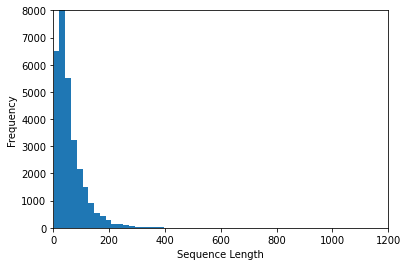

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Dựa trên biểu đồ histogram ở trên chúng ta có thể thấy là 180 là kết quả tương đối hợp lý. 

In [ ]:
maxSeqLength = 180

Để có cảm nhận rõ hơn về dữ liệu, chúng ta có thể hiển thị một số review bất kỳ như sau.

In [ ]:
print('A positive sentence: ')
fname = positiveFiles[3] # Randomly select a positive file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)

print('A negative sentence: ')
fname = negativeFiles[10] # Randomly select a negative file to view
with open(fname, encoding='utf-8') as f:
    for lines in f:
        print(lines)


A positive sentence: 
Tụi mình đến quán khoảng 8g tối hơi đông nhưng đợi cũng không lâu lắm . Thấy quán làm theo thứ_tự nên cũng yên_tâm .

Mình order trà sữa truyền_thống 1l và kem mây táo . Trà thì thơm béo vừa uống rất ngon . Kem mây chua_chua thơm lắm , bạn_gái mình ăn mà cứ khen . Tổng thiệt_hại 66k và rất hài_lòng .

A negative sentence: 
Đồ_ăn được mặc_dù không ngon bằng Thiên_Du , phục_vụ chậm , không tận_tình , lấc_cấc , order 4 món , món ra max chậm , cả 35 ' ngồi đợi ra được 1 món sushi cá_hồi 6 cục , nhân_viên lên cứ ủa ả sao món chưa lên , chi vậy chạy xuống dưới bếp mà hỏi , hỏi trên đây ai mà trả_lời , còn có nhân_viên hỏi ai order bàn này , làm như khách thuộc hết tên mấy người_làm ở đây vậy , đồ_ăn mắc gấp đôi bên Thiên_Du , súp còn phải mua trong khi bên kia được tặng mỗi người 1 chén , ăn mà tốn tiền gửi xe nữa , tự dắt vô , tự lấy ra , bảo_vệ chỉ đứng lấy tiền , nhìn 2 chị_gái kia tự dắt xe ra mà thấy tội , làm như chỗ để xe rộng lắm hay_sao á , dắt cũng khó nữa , c

## Chuẩn hoá văn bản và tách từ

Để tiết kiệm công sức và cũng nằm ngoài phạm vi của khoá học, chúng tôi đã chuẩn bị sẵn tập dữ liệu đã được tách từ. Giữa hai từ có thể ghép lại để tạo thành một khái niệm mới chúng tôi sử dụng ký tự '_' để nối các từ đó. Ví dụ: 'sinh_viên', 'sinh_học'.

Chúng tôi chuẩn bị sẵn các hàm chuẩn hoá văn bản nhằm loại bỏ các ký tự đặc biệt. Tham khảo ở hàm 'cleanSentences'.

In [ ]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^\w0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

Bây giờ chúng ta sẽ biểu diễn 30.000 review dưới dạng các chỉ số của các từ. Tập dữ liệu positive và negative sẽ được tính hợp lại thành một ma trận 30000x180. Trong đó 30000 là số lượng review và 180 là số lượng từ tối đa cho một câu. Do bước chuẩn bị này tốn khá nhiều tài nguyên tính toán nên sau khi tính toán xong, chúng ta sẽ lưu lại để sử dụng cho những lần chạy thí nghiệm sau. Ma trận lưu trữ các chỉ số này là: 'ids'.

### ToDo 3.2: xác định chỉ số của từng từ trong review

Trong phần này chúng ta sẽ tiến hành tra cứu từng từ trong review, sau đó gán vào ma trận 'ids'. Trong đó chỉ số dòng của ma trận tương ứng với file review, chỉ số cột của ma trận tương ứng với một từ của review. Trường hợp từ nào không có trong tập từ điển thì ta sẽ gán bằng chỉ số của từ 'UNK' (unknow).

In [ ]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
nFiles = 0
# Index of Unknow word
unk_idx = wordsList.index('UNK')

for pf in positiveFiles:
    with open(pf, "r", encoding="utf-8") as f:
        nIndexes = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            # TODO 3.2: Nếu 'word' thuộc tập 'wordsList' thì gán chỉ số của 'word' vào ma trận ids

            # Ngược lại: gán 'unk_idx' vào ma trận ids
            
            nIndexes = nIndexes + 1
            if nIndexes >= maxSeqLength:
                break
        nFiles = nFiles + 1 

print('Positive files are indexed!')
for nf in negativeFiles:
    with open(nf, "r", encoding="utf-8") as f:
        nIndexes = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            # ToDo 3.2: tương tự như trên. Không khác gì hết.
            
            
            nIndexes = nIndexes + 1
            if nIndexes >= maxSeqLength:
                break
        nFiles = nFiles + 1 

print('Negative files are indexed!')
# Save ids Matrix for future uses.
np.save(os.path.join(currentDir,'idsMatrix.npy'), ids)

Positive files are indexed!
Negative files are indexed!


In [ ]:
# LƯU Ý: Bước thực hiện trên tương đối mất thời gian.
# Trường hợp đã tính toán và lưu ma trận 'ids' rồi thì ta có thể load lên để sử dụng luôn
ids = np.load(os.path.join(currentDir,'idsMatrix.npy'))
print('Word indexes of the first review: ', ids[0])


Word indexes of the first review:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Nếu như quá trình chuyển từ câu dạng văn bảng sang vector các chỉ số trong từ điển ở trên đúng thì ids[0] sẽ nhận giá trị: [19898  1906  4454  5284 10661 11694 11994 18784 18569 18619 13174  9821 ...]

## Xây dựng hàm lấy dữ liệu train và test theo từng batch

Dưới đây chúng tôi xây dựng các hàm để lấy dữ liệu train và test theo từng batch. Bạn hãy giải thích tại sao lại có các con số 13999, 14999, 15999, 29999 nhé.

In [ ]:
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            # Pick positive samples randomly
            num = randint(1,13999)
            labels.append([1,0])
        else:
            # Pick negative samples randomly
            num = randint(15999,29999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(13999,15999)
        if (num <= 14999):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

# 3. Xây dựng RNN Model với Tensorflow

Đầu tiên chúng tôi sẽ khởi tạo các tham số cho mô hình mạng RNN với các cell là các LSTM. Kiến trúc mạng ở đây bao gồm 128 đơn vị cho mỗi lớp, số lượng layer là 2, số lượng phân lớp là 2 và số vòng lặp khi huấn luyện là 30000.

In [ ]:
# Initialize paramters
numDimensions = 300
batchSize = 64
lstmUnits = 128
nLayers = 2
numClasses = 2
iterations = 30000

Để lưu trữ dữ liệu input và ouput, chúng ta sẽ sử dụng hai kiểu dữ liệu placeholder. Một trong những điều quan trọng nhất khi khởi tạo các biến input và output này là xác định kích thước của các tensor. Mỗi output của mạng (hay còn gọi là label) sẽ là một vector one hot với hai giá trị tương ứng với hai loại cảm xúc: [1, 0] cho positive và [0, 1] cho negative.

![caption](Images/data_batch.png)

## ToDo 3.3: Xác định input và output

Khởi tạo hai biến 'inputs' và 'labels' bằng kiểu placeholder.

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.framework import ops
ops.reset_default_graph()

# TODO 3.3: Khởi tạo hai biến 'inputs' và 'labels'
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
inputs = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Sau đó tạo dữ liệu word vector từ khối dữ liệu đầu vào với ma trận word embedding. Nếu như quá trình khởi tạo đúng thì sẽ tạo ra các kiểu dữ liệu sau:
labels --> Tensor("Placeholder:0", shape=(64, 2), dtype=float32)
inputs --> Tensor("Placeholder_1:0", shape=(64, 10), dtype=int32)

![caption](Images/embedding_data.png)

In [ ]:
data = tf.nn.embedding_lookup(wordVectors, inputs)

Như vậy sau bước này chúng ta đã có dữ liệu để đưa vào mạng mạng các LSTM. Để khởi tạo một LSTM chúng ta sử dụng hàm tf.nn.rnn_cell.BasicLSTMCell. Hàm này cần tham số đầu vào là số lượng đơn vị muốn khởi tạo. Đây chính là một hyperparamter đã được khởi tạo trước đó.
Để chống lại việc overfitting, chúng ta sử dụng lớp dropout. 

Để tăng tính phức tạp cho kiến trúc mạng chúng ta chồng các lớp LSTM lên nhau (Stack LSTM Layers). Trong trường hợp này chúng ta sử dụng 2 lớp LSTM. Việc chồng thêm các lớp LSTM sẽ giúp cho mô hình có khả năng nhớ nhiều thông tin hơn nhưng đồng thời cũng làm tăng số lượng tham số khi huấn luyện. Điều này cũng có nghĩa là sẽ làm tăng thời gian huấn luyện cũng như là cần thêm nhiều dữ liệu hơn.

Cuối cùng là đưa toàn bộ dữ liệu đầu vào vào mạng các LSTM sử dụng hàm tf.nn.dynamic_rnn. Chi tiết kiến trúc mạng LSTM sử dụng cho bài tập này được mô tả trong hình sau:

![caption](Images/architecture.png)

In [ ]:
def generate_a_lstm_layer():
    # Khởi tạo một LSTM layer với 'lstmUnits' unit sử dụng hàm tf.contrib.rnn.BasicLSTMCell
    lstmCell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(lstmUnits)
    # Sau đó tạo một lớp dropout để chống overfitting với hệ số out_keep_prob bằng 0.75
    # Sử dụng hàm tf.contrib.rnn.DropoutWrapper

    lstmCell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
    return lstmCell

# Sau khi đã có hàm tạo một LSTM Layer, ta sử dụng hàm này để chồng các LSTM lên
# Stack các LSTM layer với hàm tf.nn.rnn_cell.MultiRNNCell
tf.compat.v1.nn.rnn_cell.MultiRNNCell = generate_a_lstm_layer
# Feed data variable vào mạng LSTM sử dụng hàm tf.nn.dynamic_rnn
outputs = tf.compat.v1.nn.dynamic_rnn(cell, data, dtype=tf.float32)
print(outputs)

Sau khi ra khỏi mạng LSTM, biến outputs sẽ là một tensor có kích thước [batchSize x maxSeqLength x lstmUnits], cụ thể là [64 x 180 x 128].

Sau đó, chúng ta chỉ lấy dữ liệu ở LSTM cell cuối cùng và cho đi qua lớp kết nối đầy đủ để phân loại thành 2 trạng thái. Chỉ số của LSTM cell cuối cùng là 179 (do có 180 cell theo chiều ngang)  nên để có thể lấy được giá trị ta sẽ chuyển vị về tensor có kích thước [maxSeqLength x batchSize x lstmUnits] hay [180 x 64 x 128]. Sử dụng hàm tf.gather để lấy tensor thứ 179 có kích thước [64 x 128] bao gồm 64 mẫu vector 128 chiều. Vector 128 chiều này sẽ được đưa vào lớp fully connected để chuyển đổi về vector 2 chiều tương ứng với 2 trạng thái.

Lớp kết nối đầy đủ bao gồm các bộ tham số 'weight' và 'bias' để thực hiện việc dự đoán kết quả. Bước này chính là tạo một lớp Fully Connected như trong sơ đồ kiến trúc mạng LSTM.

In [ ]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))

# Lấy giá trị output tại LSTM cell cuối cùng
outputs = tf.transpose(outputs, [1, 0, 2])
last = tf.gather(outputs, int(value.get_shape()[0]) - 1)
# Đưa qua mạng Fully Connected mà không có activation function
prediction = (tf.matmul(last, weight) + bias)

Để xác định độ chính xác của hệ thống, ta đếm số lượng labels khớp với giá trị dự đoán (prediction). Sau đó tính độ chính xác bằng cách tính giá trị trung bình của các kết quả trả về đúng.

In [ ]:
correctResult = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctResult, tf.float32))

Sau đó chúng ta sẽ xác định hàm độ lỗi sử dụng softmax cross entropy được tính từ dữ liệu dự đoán và tập labels. Cuối cùng là chọn thuật toán tối ưu với tham số learning rate mặc định là 0.001. 

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

## Sử dụng Tensorboard để visualize kết quả

Trong quá trình huấn luyện, chương trình sẽ ghi log về độ lỗi và độ chính xác trên tập train vào thư mục 'tensorboard', lưu lại model sau mỗi 2000 vòng lặp ở thư mục 'models'. Việc huấn luyện trên 30,000 vòng lặp mất khoảng vài tiếng với GPU K80 được cung cấp bởi Google Colab.

# 4. Huấn luyện

Với mỗi vòng lặp, ta sẽ lấy ra một batch dữ liệu train để đưa vào mạng sử dụng `feed_dict`. với các tham số input và label là các placeholders. Bước huấn luyện này được lặp lại cho đến khi hết số lần cần huấn luyện.

In [ ]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"

In [ ]:
sess = tf.InteractiveSession()
writer = tf.summary.FileWriter(logdir, sess.graph)
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
    # TODO 3.5
    # Get next training batch
    ...
    # Feed to optimizer
    ...
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

    # Save model every 2000 training iterations
    if (i % 2000 == 0 and i != 0):
        save_path = saver.save(sess, os.path.join(currentDir,"models/pretrained_lstm.ckpt"), global_step=i)
        print("saved to %s" % save_path)
writer.close()

# 5. Load mô hình đã train và đánh giá mô hình

Thời gian huấn luyện mạng khá lâu, nên trong quá trình mạng đang được huấn luyện, ta sẽ lưu lại một số checkpoint. Để có thể test thử trên một checkpoint mới nhất ta sử dụng hàm tf.train.latest_checkpoint và truyền vào tên thư mục muốn lấy model mới nhất.

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(os.path.join(currentDir,'models')))

Sau đó, với mỗi batch dữ liệu test, ta sẽ tiến hành test và tính độ chính xác

### ToDo 3.6: Test mô hình

In [ ]:
# Test on 10 batches
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch()
    # TODO 3.6: Tính độ chính xác 'accuracy' trên các test batch và gán vào 'test_acc'
    ...
    print("Accuracy for this batch:", test_acc)

Do các bộ test được lấy ngẫu nhiên nên độ chính xác trong quá trình này cũng dao động từ 70% đến 90%.

## ToDo 3.7: Viết hàm tổng hợp để dự đoán cảm xúc từ câu tiếng Việt

Câu cuối cùng này đòi hỏi đòi hỏi các bạn phải vận dụng tư duy tổng hợp để gom tất cả những bước đã thực hiện trước đó thành một quy trình hoàn chỉnh. Các bạn cần viết một hàm hoàn chỉnh với đầu vào là  một câu tiếng Việt cho trước, đầu ra là cho biết câu trên có cảm xúc tích cực hay tiêu cực.

In [ ]:
input_sentence = 'Món này ăn ngon mê ly luôn. Vị ngọt và thơm quá trời quá đất.'
# TODO 3.7 Các bạn vận dụng toàn bộ quy trình đã thực hiện trước đó
# để dự đoán xem câu này có cảm xúc tích cực hay tiêu cực
# Câu này làm khá dài và có tính chất tổng hợp




# Kết luận

Như vậy qua bài tập này, các bạn được ôn lại mô hình Word2Vec và sử dụng mô hình này để biểu diễn cho một văn bản. Sử dụng cách biểu diễn này để đưa vào mô hình RNN với nhiều đơn vị LSTM. Các bạn có thể thử nghiệm trên các cấu hình khác nhau bằng cách thay đổi các hyperparameter.